In [59]:
from models import Discriminator, UNet, Generator
from datasets import ImageDataset,tophat
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch
import torchvision
from skimage import io, morphology
import matplotlib.pyplot as plt
import numpy as np
from models import UNet,Generator
from PIL import Image,ImageOps
from tqdm import tqdm
import random
import cv2
from utils import fusion_predict, make_mask, merge_ckpts, denorm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 多角度融合

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbdfcbb5050>,
 <matplotlib.image.AxesImage at 0x7fbdfcb76850>)

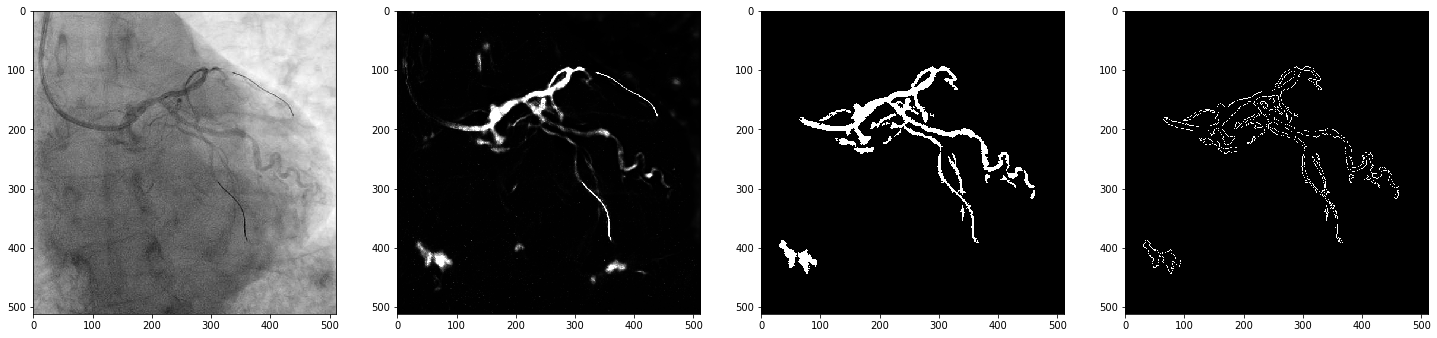

In [249]:
sz = 512
tfmc = T.Compose([
    T.Resize(sz),
#     T.Lambda(lambda img: tophat(img,50)),
#     T.CenterCrop(400),
    T.ToTensor(),
    T.Normalize((0.5),(0.5))
])

ds = ImageDataset('datasets/cycledsa_v45/', size=sz, unaligned=False, mode='test', transform=tfmc)

netG_B2A = UNet(1, 1, 32, bilinear=True)
netG_B2A = torch.nn.DataParallel(netG_B2A)
ckpts = [
#      'mlruns/3/717b1625375147ba9e7f68bf47be9296/last.ckpt', # sz512
#          'mlruns/3/887fe32048a7458aa201775b6b022128/010.ckpt', # randtophat_sz512 7-10ep加强gamma好像可以
#         'mlruns/3/887fe32048a7458aa201775b6b022128/015.ckpt', # randtophat_sz512 7-10ep加强gamma好像可以
#         'mlruns/3/887fe32048a7458aa201775b6b022128/019.ckpt', # randtophat_sz512 7-10ep加强gamma好像可以
#             'mlruns/4/1b739448a0194e1e92f159d4bbc5e965/039.ckpt', # v46
#         'mlruns/4/1b739448a0194e1e92f159d4bbc5e965/035.ckpt', # v46-tophat
#         'mlruns/4/d8ec4f94fb6c41898ccf20162c5a0ba3/059.ckpt', # v46-ep60
        'mlruns/4/ebb5a026a1264aa0a6b207adab540040/last.ckpt', # lr1e5
#             'mlruns/4/62e89ceac46145978a06cfd7ad765bfd/last.ckpt', # fulltophat
        'mlruns/4/da9110cc64c24cb08fc23984966bc62a/last.ckpt', # rot
]

# # resnet
# netG_B2A = Generator(1, 1)
# netG_B2A = torch.nn.DataParallel(netG_B2A)
# ckpts = [
#     'mlruns/0/bed13f38d5e148baac9563841815eabf/048.ckpt', # bs4_res 其他挺，但103不好
#     'mlruns/0/1d40d2833f82492c90aecdb4343bdb1a/048.ckpt', # bs4_res_noRoate sota3
#     'mlruns/0/78e1e67ae33b4c8aa95ba095f11f939f/038.ckpt', # bs4_res_tophat_noRotate
#     'mlruns/0/c03f607a02424ac98a9a612bcdfb83e4/049.ckpt', # bs4_res_tophat ★★★ 背景识别更精准
#      'mlruns/3/cc806258307844ecaa4c430acb757616/018.ckpt', # res_sz512_ep20
# ]

idx = 35
# 缺 28 57 68 815 817
# 差2 29 
# 34 813可以作为tophat融合的样本
# 病变 805 903
x = ds[idx]['B']
B,out = fusion_predict(netG_B2A, ckpts, x, multiangle=False, denoise=0, size=sz, cutoff=1, pad=0, padding_mode='reflect')
mask, skel = make_mask(out,remove_size=800, return_skel=False,local_kernel=25, hole_max_size=50)

out = T.functional.adjust_gamma(out,3)

plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B)
plt.subplot(142),plt.imshow(out)
plt.subplot(143),plt.imshow(mask,cmap='gray')
plt.subplot(144),plt.imshow(skel)

# plt.show()

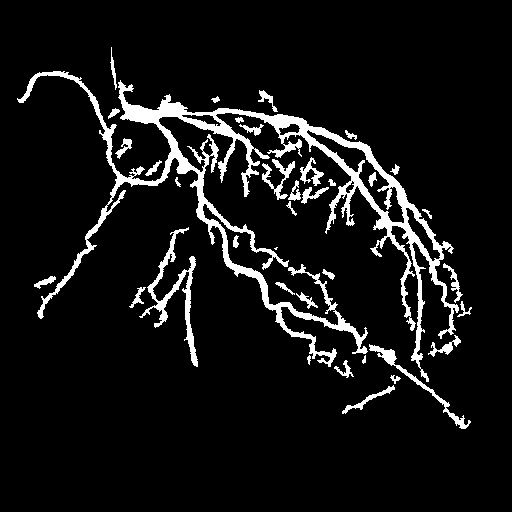

In [14]:
mask

### CKPT Merge

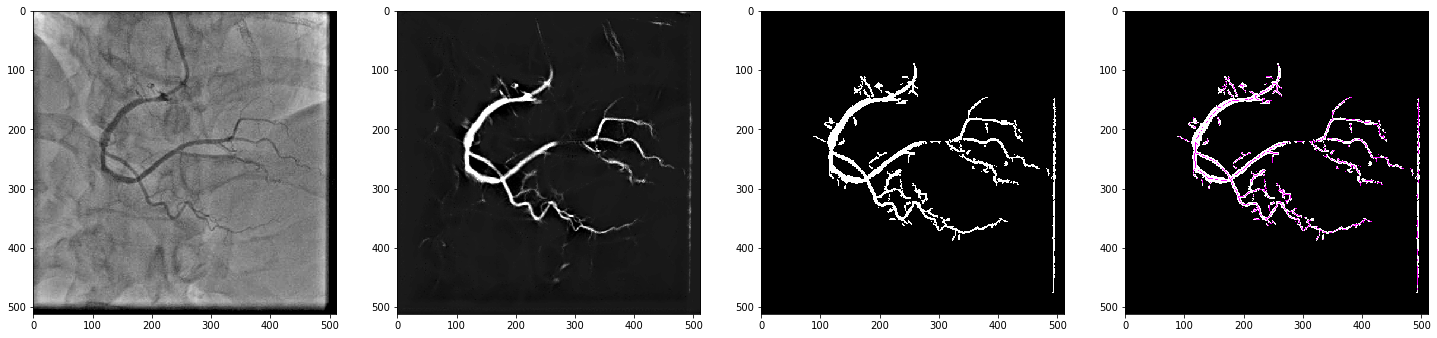

In [318]:
ckpts = []
ckpts.append(torch.load('mlruns/4/d8ec4f94fb6c41898ccf20162c5a0ba3/last.ckpt', map_location='cpu')['netG_B2A'])
ckpts.append(torch.load('mlruns/4/d8ec4f94fb6c41898ccf20162c5a0ba3/030.ckpt', map_location='cpu')['netG_B2A'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/160.ckpt', map_location='cpu')['netE'])
# ckpts.append(torch.load('mlruns/0/8f4634e9eca640beb19eb49e97da10c7/199.ckpt', map_location='cpu')['netE'])


ckptm = merge_ckpts(ckpts)

x = ds[idx]['B']
B,out = fusion_predict(netG_B2A, [ckptm], x, pad=0, multiangle=False, denoise=0, size=sz)
mask, skel = make_mask(out,remove_size=1000, return_skel=True)
out = T.functional.adjust_gamma(out,1.5)



plt.figure(figsize=(25,25))
plt.subplot(141),plt.imshow(B)
plt.subplot(142),plt.imshow(out)
plt.subplot(143),plt.imshow(mask,cmap='gray')
plt.subplot(144),plt.imshow(skel)

plt.show()